In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load the data into DataFrames
train_users = pd.read_csv('./data/train_users_2.csv')
test_users = pd.read_csv('./data/test_users.csv')

In [3]:
# Inspect data 
len(train_users.id.unique()), len(test_users.id.unique()), train_users.shape, test_users.shape

(213451, 62096, (213451, 16), (62096, 15))

In [4]:
# Merge train and test users
users = pd.concat((train_users, test_users), axis=0)
users.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,gxn3p5htnn,en,Web,0,facebook,20090319043255
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,820tgsjxq7,en,Web,0,facebook,20090523174809
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,en,Web,3,basic,20090609231247
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,en,Web,0,facebook,20091031060129
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,87mebub9p4,en,Web,0,basic,20091208061105


In [5]:
# Replace null in Gender field
users.gender.replace('-unknown-', np.nan, inplace=True)

In [6]:
# Change Dates columns to Python Date format
users['date_account_created'] = pd.to_datetime(users['date_account_created'], format='%Y-%m-%d')
users['timestamp_first_active'] = pd.to_datetime(users['timestamp_first_active'], format='%Y%m%d%H%M%S')
#users['date_account_created'].fillna(df_all.timestamp_first_active, inplace=True)

In [7]:
# Nullify outliers
users.loc[users['age'] > 90,'age'] = np.NaN
users.loc[users['age'] < 15,'age'] = np.NaN

print len(users[users['age'] > 90])
print len(users[users['age'] < 15])
print len(users[users['age'].isnull()])

0
0
119853


In [8]:
# Extract Date Features
import datetime as dt
users['day_account_created'] = users['date_account_created'].dt.weekday
users['month_account_created'] = users['date_account_created'].dt.month
users['quarter_account_created'] = users['date_account_created'].dt.quarter
users['year_account_created'] = users['date_account_created'].dt.year
users['hour_first_active'] = users['timestamp_first_active'].dt.hour
users['day_first_active'] = users['timestamp_first_active'].dt.weekday
users['month_first_active'] = users['timestamp_first_active'].dt.month
users['quarter_first_active'] = users['timestamp_first_active'].dt.quarter
users['year_first_active'] = users['timestamp_first_active'].dt.year
users['created_less_active'] = (users['date_account_created'] - users['timestamp_first_active']).dt.days

In [9]:
users = users.fillna({'age':-1})

In [10]:
t_users = users.copy()
t_users = t_users.set_index('id')

cat_features = ['affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'first_browser',
 'first_device_type',
 'gender',
 'language',
 'signup_app',
 'signup_flow',
 'signup_method']
num_features = ['day_account_created',
 'month_account_created',
 'quarter_account_created',
 'year_account_created',
 'hour_first_active',
 'day_first_active',
 'month_first_active',
 'quarter_first_active',
 'year_first_active',
 'created_less_active',
 'age']
target = ['country_destination']

In [11]:
nogender_cat_features = ['affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'first_browser',
 'first_device_type',
 'language',
 'signup_app',
 'signup_flow',
 'signup_method']

other_features = ['day_account_created',
 'month_account_created',
 'quarter_account_created',
 'year_account_created',
 'hour_first_active',
 'day_first_active',
 'month_first_active',
 'quarter_first_active',
 'year_first_active',
 'created_less_active',
 'age',
 'gender']

In [12]:
encode_users = pd.get_dummies(t_users[nogender_cat_features])

In [13]:
encode_users.shape, t_users[num_features].shape

((275547, 132), (275547, 11))

In [14]:
df_users = pd.merge(encode_users, t_users[other_features], how='inner', left_index=True, right_index=True)

In [15]:
df_users.shape

(275547, 144)

In [16]:
# Join/Merge with session data
user_devices = pd.read_csv('./data/user_devices.csv')
user_session = pd.read_csv('./data/user_session_detail.csv')

In [17]:
df_users = df_users.reset_index()

In [18]:
all_users = pd.merge(df_users, user_devices, how='left', left_on='id', right_on='user_id')
all_users = pd.merge(all_users, user_session, how='left', left_on='id', right_on='user_id')

In [19]:
all_users.shape

(275547, 316)

In [20]:
# Split notnull vs null gender
X_gender_users = all_users[all_users['gender'].isnull()==False]
X_pred_gender_users = all_users[all_users['gender'].isnull()]

In [21]:
y_gender_users = X_gender_users['gender']

In [24]:
id_X = X_gender_users.id
id_X_pred = X_pred_gender_users.id

In [25]:
X_gender_users = X_gender_users.drop(['gender','user_id_x','user_id_y','id'], axis=1)
X_pred_gender_users = X_pred_gender_users.drop(['gender','user_id_x','user_id_y','id'], axis=1)

In [28]:
X_gender_users = X_gender_users.fillna(0)
X_pred_gender_users = X_pred_gender_users.fillna(0)

In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_y_gender_users = le.fit_transform(y_gender_users)

In [30]:
X_gender_users.shape, X_pred_gender_users.shape

((146067, 312), (129480, 312))

In [31]:
np.bincount(le_y_gender_users)

array([77524, 68209,   334])

In [32]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_gender_users, le_y_gender_users)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

In [33]:
pred_gender = neigh.predict(X_pred_gender_users)

In [34]:
np.bincount(pred_gender)

array([78235, 51245])

In [35]:
X_pred_gender_users['predicted_gender'] = le.inverse_transform(pred_gender)

In [36]:
impute_gender = pd.DataFrame(X_pred_gender_users['predicted_gender'])

In [37]:
impute_gender.head()

,predicted_gender
0,FEMALE
4,MALE
5,FEMALE
9,FEMALE
12,FEMALE


In [38]:
new_all_users = pd.merge(all_users, impute_gender, how='left', left_index=True, right_index=True)

In [39]:
new_all_users.shape, all_users.shape

((275547, 317), (275547, 316))

In [40]:
new_all_users.head()

,id,signup_flow,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,...,view_search_results,view_security_checks,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips,predicted_gender
0,gxn3p5htnn,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FEMALE
1,820tgsjxq7,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,3,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MALE


In [42]:
new_all_users.loc[new_all_users.gender.isnull(),'gender'] = new_all_users['predicted_gender']

In [44]:
new_all_users.gender.isnull().sum()

0

In [46]:
#new_all_users.to_csv('new_all_users_backup.csv')

In [47]:
new_all_users = new_all_users.drop(['user_id_x','user_id_y','predicted_gender'], axis=1)

In [49]:
# One-hot encoding Gender feature
new_all_users = new_all_users.set_index('id')
new_all_users = pd.get_dummies(new_all_users)

In [51]:
new_all_users.shape

(275547, 315)

In [54]:
new_all_users.head()

,signup_flow,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_baidu,...,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips,gender_FEMALE,gender_MALE,gender_OTHER
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,0,0,0,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
820tgsjxq7,0,0,0,0,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
4ft3gnwmtx,3,0,0,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
bjjt8pjhuk,0,0,0,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
87mebub9p4,0,0,0,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0


In [53]:
len(new_all_users[new_all_users['age'] == -1])

119853

In [56]:
new_all_users.age.describe()

count    275547.000000
mean         19.885921
std          20.241198
min          -1.000000
25%          -1.000000
50%          25.000000
75%          34.000000
max          90.000000
Name: age, dtype: float64

In [57]:
new_all_users = new_all_users.reset_index()

In [58]:
new_all_users.head()

,id,signup_flow,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,...,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips,gender_FEMALE,gender_MALE,gender_OTHER
0,gxn3p5htnn,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
1,820tgsjxq7,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
2,4ft3gnwmtx,3,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
3,bjjt8pjhuk,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
4,87mebub9p4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0


In [59]:
# Split notnull vs null age (or age = -1)
X_age_users = new_all_users[new_all_users['age'] != -1]
X_pred_age_users = new_all_users[new_all_users['age'] == -1]
y_age_users = X_age_users['age']

id_X = X_age_users.id
id_X_pred = X_pred_age_users.id

In [64]:
# Drop age from the dataset to be trained
X_age_users = X_age_users.drop('age', axis=1)
X_pred_age_users = X_pred_age_users.drop('age', axis=1)

In [68]:
# Fill NA other fields
X_age_users = X_age_users.fillna(0)
X_pred_age_users = X_pred_age_users.fillna(0)

In [71]:
# Drop age from the dataset to be trained
X_age_users = X_age_users.drop('id', axis=1)
X_pred_age_users = X_pred_age_users.drop('id', axis=1)

In [72]:
X_age_users.shape, X_pred_age_users.shape, y_age_users.shape

((155694, 314), (119853, 314), (155694,))

In [73]:
# Train K-NN = 5 model to predict mean of 5 nearest neighbors of the records without age
from sklearn.neighbors import KNeighborsRegressor
neigh_regr = KNeighborsRegressor(n_neighbors=5)
neigh_regr.fit(X_age_users, y_age_users)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=5, p=2, weights='uniform')

In [74]:
pred_age = neigh_regr.predict(X_pred_age_users)

In [81]:
new_all_users.head(10)

,id,signup_flow,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,...,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips,gender_FEMALE,gender_MALE,gender_OTHER
0,gxn3p5htnn,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
1,820tgsjxq7,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
2,4ft3gnwmtx,3,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
3,bjjt8pjhuk,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
4,87mebub9p4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
5,osr2jwljor,0,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
6,lsw9q7uk0j,0,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
7,0d01nltbrs,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
8,a1vcnhxeij,0,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
9,6uh8zyj2gn,0,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0


In [79]:
X_pred_age_users['predicted_age'] = pred_age

In [80]:
X_pred_age_users.head()

,signup_flow,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_baidu,...,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips,gender_FEMALE,gender_MALE,gender_OTHER,predicted_age
0,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,43.2
5,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,33.8
12,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,33.4
16,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,34.0
18,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,33.6


In [82]:
impute_age = pd.DataFrame(X_pred_age_users['predicted_age'])

In [83]:
impute_age.head()

,predicted_age
0,43.2
5,33.8
12,33.4
16,34.0
18,33.6


In [84]:
df_all_users = pd.merge(new_all_users, impute_age, how='left', left_index=True, right_index=True)

In [86]:
df_all_users.loc[df_all_users.age == -1,'age'] = df_all_users['predicted_age']

In [88]:
len(df_all_users[df_all_users.age == -1])

0

In [90]:
# Prepare for XGboost prediction of country destination
df_all_users = df_all_users.drop('predicted_age', axis=1)

In [91]:
df_all_users.head()

,id,signup_flow,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,...,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips,gender_FEMALE,gender_MALE,gender_OTHER
0,gxn3p5htnn,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
1,820tgsjxq7,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
2,4ft3gnwmtx,3,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
3,bjjt8pjhuk,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
4,87mebub9p4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0


In [92]:
destination = t_users['country_destination'].reset_index()

In [93]:
destination.head()

,id,country_destination
0,gxn3p5htnn,NDF
1,820tgsjxq7,NDF
2,4ft3gnwmtx,US
3,bjjt8pjhuk,other
4,87mebub9p4,US


In [95]:
df_all_users = df_all_users.fillna(0)

In [97]:
df_all_users = pd.merge(df_all_users, destination, how='inner', on='id')

In [98]:
df_all_users.shape

(275547, 317)

In [99]:
# Split train and test data
df_test = df_all_users[df_all_users['country_destination'].isnull()]
df_train = df_all_users[df_all_users['country_destination'].isnull()==False]

In [100]:
df_test.shape, df_train.shape

((62096, 317), (213451, 317))

In [101]:
from sklearn.preprocessing import LabelEncoder
labels = df_train['country_destination']
le = LabelEncoder()
y = le.fit_transform(labels)
X = df_train.drop('country_destination', axis=1, inplace=False)

In [102]:
idtrain = df_train['id']
X = X.drop('id', axis=1, inplace=False)

In [103]:
X.shape, y.shape

((213451, 315), (213451,))

In [104]:
# Model 2
# Grid Search - Used to find best combination of parameters
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search

# Skip Grid search for time saving
final_model = XGBClassifier(
        learning_rate =0.1,
        n_estimators=25,
        max_depth=3,
        objective='multi:softprob', 
        subsample=0.5, 
        colsample_bytree=0.5, 
        seed=0)
final_model.fit(X,y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=25, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)

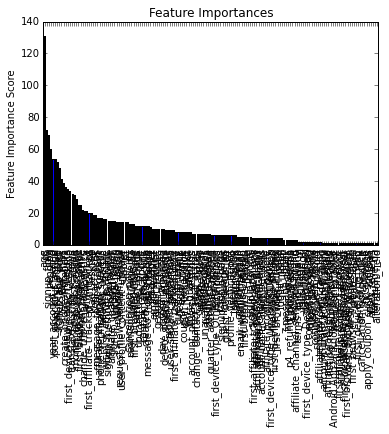

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline
feat_imp = pd.Series(final_model.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [106]:
feat_imp[:30]

age                                  131
p5                                    72
signup_flow                           69
pending                               60
year_account_created                  54
post_checkout_action                  54
year_first_active                     52
signup_app_Web                        48
message_post                          41
your_trips                            39
create_phone_numbers                  36
view_search_results                   35
first_device_type_Mac Desktop         34
translate_listing_reviews             32
hour_first_active                     31
month_account_created                 29
listing_reviews_page                  25
first_browser_-unknown-               25
month_first_active                    22
change_trip_characteristics           21
-unknown-_y                           21
first_affiliate_tracked_untracked     20
p3                                    20
Mac Desktop                           19
contact_host    

In [108]:
#Prepare data for prediction
df_test = df_test.drop('country_destination', axis=1, inplace=False)
id_test = df_test['id']
X_test = df_test.drop('id', axis=1, inplace=False)
X_test.shape

(62096, 315)

In [109]:
# Make predictions
y_pred = final_model.predict_proba(X_test)

In [110]:
id_test = id_test.reset_index()
ids_test = id_test.id.values

In [111]:
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(ids_test)):
    idx = ids_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

In [112]:
len(ids), len(cts), ids[:10], cts[:10]

(310480,
 310480,
 ['5uwns89zht',
  '5uwns89zht',
  '5uwns89zht',
  '5uwns89zht',
  '5uwns89zht',
  'jtl0dijy2j',
  'jtl0dijy2j',
  'jtl0dijy2j',
  'jtl0dijy2j',
  'jtl0dijy2j'],
 ['NDF', 'US', 'other', 'FR', 'IT', 'NDF', 'US', 'other', 'FR', 'IT'])

In [113]:
#Generate submission
print("Outputting final results...")
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('./data/submission-2016-11-01-r1csv', index=False)

Outputting final results...


In [114]:
sub.shape, df_test.shape

((310480, 2), (62096, 316))